# Research and development predicated on Lesson 03. Image segmentation with CamVid.

In [1]:
import fastai
fastai.__version__

'1.0.52'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = '/content/drive/My Drive/'
base_dir = root_dir + 'fastai_research'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID, dest=base_dir+'/datasets/')
path.ls()

[PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/labels'),
 PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/codes.txt'),
 PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/valid.txt'),
 PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

Let's explore and visualize the data.

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/images/0001TP_009300.png'),
 PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/images/0001TP_008490.png'),
 PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/images/0006R0_f03780.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/labels/0016E5_07999_P.png'),
 PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/labels/0016E5_08023_P.png'),
 PosixPath('/content/drive/My Drive/fastai_research/datasets/camvid/labels/0006R0_f03780_P.png')]

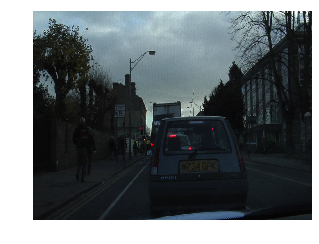

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

Let's get the label, the image segmentation, the mask.

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

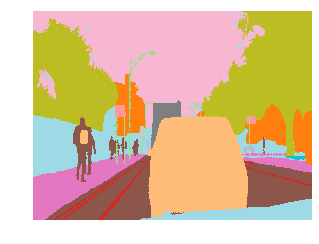

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size/2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else: bs=4
print(f"Using bs={bs}, have {free} MB of GPU RAM free")

Using bs=8, have 15068 MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))